In [1]:
## download songlyrics.zip from Kaggle, requires log in
## https://www.kaggle.com/mousehead/songlyrics/downloads/songlyrics.zip

## tf from scratch: 
## https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [2]:
import logging
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from gensim.models.word2vec import Word2Vec
from nltk import sent_tokenize, word_tokenize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
data = pd.read_csv('./data/kaggle_lyrics/songlyrics.zip')
data.drop(columns=['link'], inplace=True)
data.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante","Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [5]:
## use kaggle data set on 57,650 songs (check if it has artists for text generation)
artist_names = ['Eric Clapton', 'Jimi Hendrix', 'Bob Dylan', 'Muddy Waters', 'Eagles']
for artist_name in artist_names:
    print('There are {:03d} songs set for {}.'.format(
        len(data[data['artist'].str.contains(artist_name)]), artist_name))

There are 152 songs set for Eric Clapton.
There are 127 songs set for Jimi Hendrix.
There are 188 songs set for Bob Dylan.
There are 000 songs set for Muddy Waters.
There are 041 songs set for Eagles.


In [6]:
## add songs from the Genius catalog, for which we'll train the text generating model
for artist_name in artist_names:
    file_path = './data/lyrics_by_artist/{}.json'.format(
        artist_name.replace(' ',''))
    if os.path.isfile(file_path):
        with open(file_path) as f:
            tmp = json.load(f)
        for i in range(0, len(tmp['artists'][0]['songs'])):
            data = data.append({'artist': artist_name,
                         'song': tmp['artists'][0]['songs'][i]['title'],
                         'text': tmp['artists'][0]['songs'][i]['lyrics']},
                       ignore_index=True)

In [7]:
data.tail()

,artist,song,text
59396,Eagles,Wasted Time,"Well baby, there you stand\nWith your little h..."
59397,Eagles,What Do I Do With My Heart,You don't have to say a word\nI can see it in ...
59398,Eagles,Witchy Woman,1 Don Henley\nRaven hair & ruby lips\nSparks ...
59399,Eagles,You Are Not Alone,Say goodbye to all your pain and sorrow\nSay g...
59400,Eagles,You Never Cry Like A Lover,You never cry like a lover should\nSigh when i...


In [8]:
%%time
data['text'] = data['text'].apply(lambda text: word_tokenize(text.replace('\n', '. ')))

CPU times: user 4min 28s, sys: 2.14 s, total: 4min 30s
Wall time: 4min 32s


In [9]:
%%time
## train word2vec nn to generate embeddings
model = Word2Vec(data['text'].tolist(), size=128, window=10, min_count=10, workers=6, sg=0, hs=0)
model.train(data['text'].tolist(), total_examples=len(data['text']), epochs=10)
# note: sg=0,1 (skip gram or cbow by default)
# note: hs=0,1 (hierarchical softmax or negative sampling by default)

model.wv.most_similar(positive=['man', 'cold'], negative=[], topn=5)

2018-09-06 22:34:35,410 : INFO : collecting all words and their counts
2018-09-06 22:34:35,411 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-09-06 22:34:35,919 : INFO : PROGRESS: at sentence #10000, processed 2843150 words, keeping 46342 word types
2018-09-06 22:34:36,452 : INFO : PROGRESS: at sentence #20000, processed 5778998 words, keeping 69244 word types
2018-09-06 22:34:36,962 : INFO : PROGRESS: at sentence #30000, processed 8605139 words, keeping 86151 word types
2018-09-06 22:34:37,518 : INFO : PROGRESS: at sentence #40000, processed 11562789 words, keeping 101802 word types
2018-09-06 22:34:38,084 : INFO : PROGRESS: at sentence #50000, processed 14573663 words, keeping 117756 word types
2018-09-06 22:34:38,597 : INFO : collected 129183 word types from a corpus of 17307744 raw words and 59401 sentences
2018-09-06 22:34:38,597 : INFO : Loading a fresh vocabulary
2018-09-06 22:34:38,734 : INFO : effective_min_count=10 retains 24603 unique words (

2018-09-06 22:35:15,299 : INFO : EPOCH 5 - PROGRESS: at 80.85% examples, 1506120 words/s, in_qsize 11, out_qsize 0
2018-09-06 22:35:16,299 : INFO : EPOCH 5 - PROGRESS: at 95.46% examples, 1522394 words/s, in_qsize 11, out_qsize 0
2018-09-06 22:35:16,636 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-09-06 22:35:16,643 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-09-06 22:35:16,644 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-06 22:35:16,645 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-06 22:35:16,650 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-06 22:35:16,651 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-06 22:35:16,651 : INFO : EPOCH - 5 : training on 17307744 raw words (11269180 effective words) took 7.4s, 1526285 effective words/s
2018-09-06 22:35:16,653 : INFO : training on a 86538720 raw words (56349923 effectiv

2018-09-06 22:35:53,617 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-06 22:35:53,618 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-06 22:35:53,624 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-06 22:35:53,625 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-06 22:35:53,625 : INFO : EPOCH - 5 : training on 17307744 raw words (11270359 effective words) took 7.4s, 1514163 effective words/s
2018-09-06 22:35:54,635 : INFO : EPOCH 6 - PROGRESS: at 14.06% examples, 1521138 words/s, in_qsize 11, out_qsize 0
2018-09-06 22:35:55,636 : INFO : EPOCH 6 - PROGRESS: at 27.05% examples, 1508974 words/s, in_qsize 11, out_qsize 0
2018-09-06 22:35:56,638 : INFO : EPOCH 6 - PROGRESS: at 39.51% examples, 1473843 words/s, in_qsize 10, out_qsize 1
2018-09-06 22:35:57,643 : INFO : EPOCH 6 - PROGRESS: at 53.97% examples, 1489958 words/s, in_qsize 11, out_qsize 0
2018-09-06 22:35:58,645 : INFO : EPO

2018-09-06 22:36:33,658 : INFO : training on a 173077440 raw words (112702109 effective words) took 77.0s, 1463634 effective words/s
2018-09-06 22:36:33,661 : INFO : precomputing L2-norms of word weight vectors


CPU times: user 7min 59s, sys: 6.24 s, total: 8min 5s
Wall time: 1min 58s


/Users/hkarimi/venvs/py36_dev/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [10]:
## build vocab and embedding matrix
vocab = list(model.wv.vocab)
embedding_matrix = model.wv[vocab] # shape = [vocab_size, embedding_size]
df = pd.DataFrame(embedding_matrix, index=vocab, columns=[
    'comp'+str(i) for i in range(0, embedding_matrix.shape[1])])
print('{} words picked up.'.format(len(vocab)))

24603 words picked up.


In [11]:
## save vocabulary and embedding matrix
np.save('./data/vocab.npy', vocab)
np.save('./data/embedding_matrix.npy', embedding_matrix)

In [12]:
def find_clustered_embeddings(embeddings, distance_threshold, sample_threshold):
    ''' 
    Find only the closely clustered embeddings. 
    This gets rid of more sparsly distributed word embeddings and make the visualization clearer
    This is useful for t-SNE visualization
    
    distance_threshold: maximum distance between two points to qualify as neighbors
    sample_threshold: number of neighbors required to be considered a cluster
    '''
    
    # calculate cosine similarity
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm
    
    # make all the diagonal entries zero otherwise this will be picked as highest
    np.fill_diagonal(cosine_sim, -1.0)
    
    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim
    # find the maximums in a loop to count if there are more than n items above threshold
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1
    
    max_cosine_sim = np.max(mod_cos_sim,axis=1)

    return np.where(max_cosine_sim>distance_threshold)[0]

In [13]:
%%time
## tsne and visualize
num_embeddings = 4000
selected_embeddings = embedding_matrix[:num_embeddings,:]

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, verbose=1).fit_transform(
    selected_embeddings)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.020s...
[t-SNE] Computed neighbors for 4000 samples in 4.185s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 2.424420
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.048325
[t-SNE] Error after 2500 iterations: 2.553958
CPU times: user 6min 16s, sys: 24.9 s, total: 6min 41s
Wall time: 6min 44s


In [14]:
print('Pruning the T-SNE embeddings')
# prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
selected_ids = find_clustered_embeddings(selected_embeddings, 0.03, 1)
tsne_plot = tsne[selected_ids,:]

print('Out of ', num_embeddings, ' samples, ',
      selected_ids.shape[0],' samples were selected by pruning.')

Pruning the T-SNE embeddings
Out of  4000  samples,  277  samples were selected by pruning.


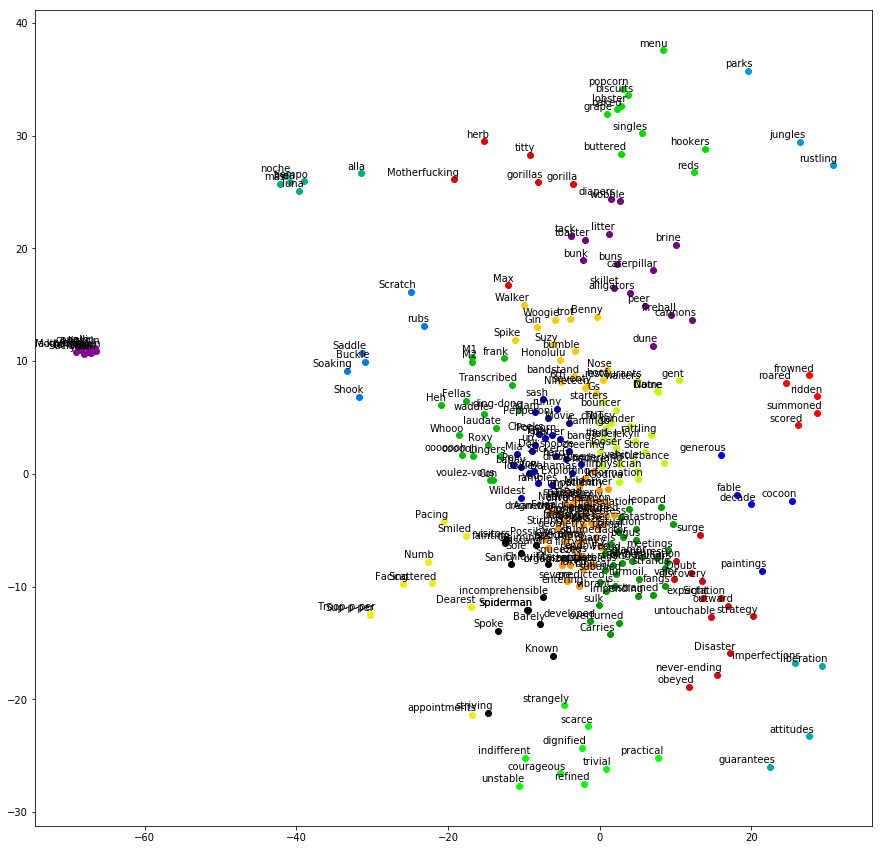

In [15]:
def plot_tsne(embeddings, labels):

    n_clusters = 20 # number of clusters

    # automatically build a discrete set of colors, each for cluster
    color_map = plt.get_cmap('nipy_spectral')
    label_colors = [color_map(float(i)/n_clusters) for i in range(n_clusters)]

    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'

    # Define K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
    kmeans_labels = kmeans.labels_

    plt.figure(figsize=(15,15))  # in inches

    # plot all the embeddings and their corresponding words
    for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
        x, y = embeddings[i,:]
        plt.scatter(x, y, c=label_colors[klabel])    

        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)

    # use for saving the figure if needed
    #plt.savefig('word_embeddings.png')
    plt.show()

vocab_plot = [vocab[i] for i in selected_ids]
plot_tsne(tsne_plot, vocab_plot)